# CUR – Dimensionality Reduction

# Import các thư viện cần thiết

Dữ liệu gốc - RMSE huấn luyện: 0.30041878043564935
Dữ liệu gốc - RMSE kiểm tra: 0.3319684688284752
Dữ liệu đã biến đổi - RMSE huấn luyện: 0.6927415815080559
Dữ liệu đã biến đổi - RMSE kiểm tra: 0.9438430375914204


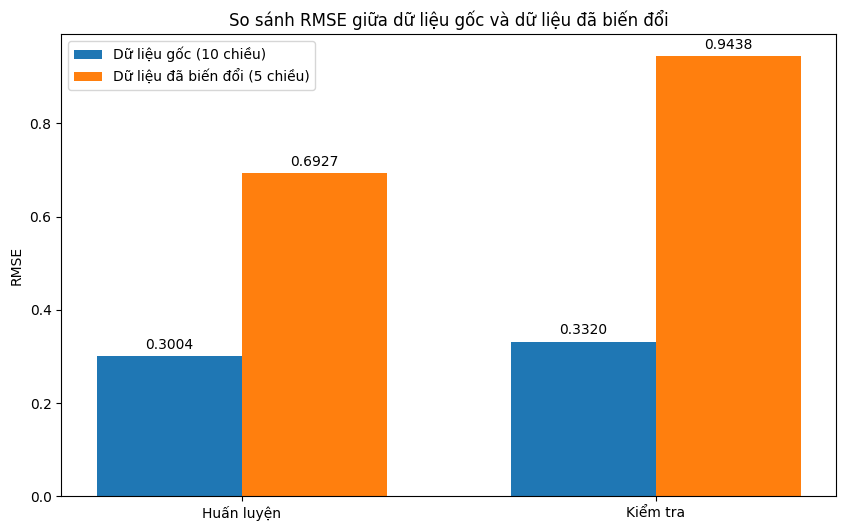

In [ ]:
## Import các thư viện cần thiết
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, collect_list, size
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, DoubleType
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg import Vectors as MLLibVectors
import numpy as np
import matplotlib.pyplot as plt
import random

# Khởi tạo SparkSession
spark = SparkSession.builder.appName("CUR_Dimensionality_Reduction").getOrCreate()

# Triển khai lớp phân rã CUR
class CURDecomposition:
    def __init__(self, k=5):
        """
        Khởi tạo phân rã CUR với số thành phần cần giữ lại.

        Tham số:
            k (int): Số thành phần cần giữ lại (chiều dữ liệu sau khi giảm)
        """
        self.k = k
        self.C = None
        self.U = None
        self.R = None
        self.leverage_scores_col = None
        self.leverage_scores_row = None
        self.selected_cols = None
        self.selected_rows = None

    def fit(self, data_matrix):
        """
        Áp dụng phân rã CUR trên ma trận dữ liệu đầu vào.

        Tham số:
            data_matrix (RowMatrix): Ma trận dữ liệu đầu vào

        Trả về:
            self: Đối tượng phân rã đã được áp dụng
        """
        # Chuyển đổi sang định dạng RowMatrix nếu cần
        if not isinstance(data_matrix, RowMatrix):
            data_matrix = RowMatrix(data_matrix)

        # Tính toán SVD
        svd = data_matrix.computeSVD(self.k, computeU=True)
        s = svd.s
        U = svd.U
        V = svd.V

        # Tính điểm leverage cho các cột
        # Chuyển ma trận V sang định dạng numpy để dễ truy cập
        v_array = V.toArray()
        self.leverage_scores_col = []

        # Tính các điểm leverage cho cột
        for j in range(v_array.shape[1]):  # Lặp qua các cột
            score = 0
            for k in range(self.k):
                # Lấy phần tử tại vị trí (k, j) của ma trận V
                score += (v_array[k, j] ** 2) / s[k]
            self.leverage_scores_col.append(score)

        # Tính điểm leverage cho các hàng
        self.leverage_scores_row = []
        u_local = U.rows.collect()

        # Tính các điểm leverage cho hàng
        for i in range(U.numRows()):
            score = 0
            for k in range(self.k):
                score += (u_local[i][k] ** 2) / s[k]
            self.leverage_scores_row.append(score)

        # Chọn cột và hàng dựa trên điểm leverage
        total_cols = len(self.leverage_scores_col)
        total_rows = len(self.leverage_scores_row)

        # Chọn cột với xác suất tỷ lệ thuận với điểm leverage
        col_prob = [score / sum(self.leverage_scores_col) for score in self.leverage_scores_col]
        self.selected_cols = np.random.choice(range(total_cols), size=self.k, replace=False, p=col_prob)

        # Chọn hàng với xác suất tỷ lệ thuận với điểm leverage
        row_prob = [score / sum(self.leverage_scores_row) for score in self.leverage_scores_row]
        self.selected_rows = np.random.choice(range(total_rows), size=self.k, replace=False, p=row_prob)

        # Xây dựng các ma trận C, U và R
        original_matrix = data_matrix.rows.collect()

        # Xây dựng ma trận C
        self.C = []
        for i in range(len(original_matrix)):
            row = []
            for j in self.selected_cols:
                row.append(original_matrix[i][j])
            self.C.append(row)

        # Xây dựng ma trận R
        self.R = []
        for i in self.selected_rows:
            self.R.append(original_matrix[i])

        # Xây dựng ma trận U (giả nghịch đảo)
        W = []
        for i in self.selected_rows:
            row = []
            for j in self.selected_cols:
                row.append(original_matrix[i][j])
            W.append(row)

        # Tính giả nghịch đảo của W sử dụng numpy
        W_np = np.array(W)
        W_pinv = np.linalg.pinv(W_np)
        self.U = W_pinv

        return self

    def transform(self, data):
        """
        Biến đổi dữ liệu đầu vào sử dụng phân rã CUR đã được áp dụng.

        Tham số:
            data: Dữ liệu đầu vào cần biến đổi

        Trả về:
            transformed_data: Dữ liệu đã được biến đổi với chiều giảm
        """
        if isinstance(data, RowMatrix):
            # Biến đổi dữ liệu RowMatrix
            original_matrix = data.rows.collect()
            transformed_data = []

            for row in original_matrix:
                new_row = []
                for col_idx in self.selected_cols:
                    new_row.append(row[col_idx])
                transformed_data.append(new_row)

            return transformed_data
        elif hasattr(data, 'map'):
            # Biến đổi dữ liệu RDD
            return data.map(lambda row: [row[col_idx] for col_idx in self.selected_cols])
        else:
            # Biến đổi dữ liệu danh sách Python
            transformed_data = []
            for row in data:
                new_row = []
                for col_idx in self.selected_cols:
                    new_row.append(row[col_idx])
                transformed_data.append(new_row)
            return transformed_data

# Đọc dữ liệu từ Task 2
df = spark.read.csv("/content/gold_prices.csv", header=True, inferSchema=True)
df = df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd")).orderBy("Date")

# Tạo cửa sổ trượt cho đặc trưng (giá vàng của 10 ngày trước)
window_size = 10
w = Window.orderBy("Date").rowsBetween(-window_size, -1)

# Thu thập giá của 10 ngày trước làm đặc trưng và giá hiện tại làm nhãn
df_sliding = df.withColumn("features_array", collect_list("Buy Price").over(w)) \
               .withColumn("label", col("Buy Price"))

# Lọc các hàng không có đủ lịch sử
df_filtered = df_sliding.filter(size("features_array") == window_size)

# Chuyển đổi mảng thành vector
to_vector_udf = udf(lambda x: Vectors.dense(x), VectorUDT())
final_df = df_filtered.withColumn("features", to_vector_udf("features_array")) \
                      .select("features", "label")

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra (70% huấn luyện, 30% kiểm tra)
train_df, test_df = final_df.randomSplit([0.7, 0.3], seed=42)

# Chuyển đổi sang định dạng RDD của MLLib cho RowMatrix
train_rdd = train_df.rdd.map(lambda row: MLLibVectors.dense(row.features.toArray()))
test_rdd = test_df.rdd.map(lambda row: MLLibVectors.dense(row.features.toArray()))

# Tạo RowMatrix từ RDD
train_matrix = RowMatrix(train_rdd)

# Áp dụng phân rã CUR
cur = CURDecomposition(k=5)
cur.fit(train_matrix)

# Biến đổi dữ liệu huấn luyện và kiểm tra
train_transformed = cur.transform(train_matrix)
test_transformed = cur.transform(test_rdd.collect())

# Chuyển đổi lại thành DataFrame cho mô hình hồi quy tuyến tính
train_labels = [row.label for row in train_df.collect()]
test_labels = [row.label for row in test_df.collect()]

train_transform_df = spark.createDataFrame(
    [(Vectors.dense(row), label) for row, label in zip(train_transformed, train_labels)],
    ["features", "label"]
)

test_transform_df = spark.createDataFrame(
    [(Vectors.dense(row), label) for row, label in zip(test_transformed, test_labels)],
    ["features", "label"]
)

# Huấn luyện và đánh giá mô hình hồi quy tuyến tính trên dữ liệu gốc
lr_original = LinearRegression(featuresCol="features", labelCol="label", maxIter=25)
lr_model_original = lr_original.fit(train_df)
training_loss_original = lr_model_original.summary.rootMeanSquaredError
predictions_original = lr_model_original.transform(test_df)
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
test_loss_original = evaluator.evaluate(predictions_original)

# Huấn luyện và đánh giá mô hình hồi quy tuyến tính trên dữ liệu đã biến đổi
lr_transformed = LinearRegression(featuresCol="features", labelCol="label", maxIter=25)
lr_model_transformed = lr_transformed.fit(train_transform_df)
training_loss_transformed = lr_model_transformed.summary.rootMeanSquaredError
predictions_transformed = lr_model_transformed.transform(test_transform_df)
test_loss_transformed = evaluator.evaluate(predictions_transformed)

# In kết quả
print(f"Dữ liệu gốc - RMSE huấn luyện: {training_loss_original}")
print(f"Dữ liệu gốc - RMSE kiểm tra: {test_loss_original}")
print(f"Dữ liệu đã biến đổi - RMSE huấn luyện: {training_loss_transformed}")
print(f"Dữ liệu đã biến đổi - RMSE kiểm tra: {test_loss_transformed}")

# Vẽ biểu đồ so sánh
labels = ['Huấn luyện', 'Kiểm tra']
original_losses = [training_loss_original, test_loss_original]
transformed_losses = [training_loss_transformed, test_loss_transformed]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, original_losses, width, label='Dữ liệu gốc (10 chiều)')
rects2 = ax.bar(x + width/2, transformed_losses, width, label='Dữ liệu đã biến đổi (5 chiều)')

ax.set_ylabel('RMSE')
ax.set_title('So sánh RMSE giữa dữ liệu gốc và dữ liệu đã biến đổi')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Thêm giá trị chính xác lên đầu mỗi cột
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()